In [1]:
import os
import sys
import string
import subprocess
import xarray as xr
import rasterio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import MFDataset
from netCDF4 import Dataset
from IPython.display import display, Math, Latex
import pandas as pd
from matplotlib import cm
import datetime
from datetime import datetime, timedelta
from operator import * 
from matplotlib.dates import DateFormatter


In [2]:
import netCDF4
import os
print(netCDF4.__file__)
print(os.path.dirname(netCDF4.__file__))

/Users/bilir/miniforge3/lib/python3.12/site-packages/netCDF4/__init__.py
/Users/bilir/miniforge3/lib/python3.12/site-packages/netCDF4


In [3]:
path_CBF_old=os.getcwd()+'/../Global/Global4x5/CBF_1100HF_DF14/'

filelist_cbf1100old=[]
filelist_cbf1100new=[]

for root, dirs, files in os.walk(path_CBF_old):
    for file in list([x for x in files if 'DS' not in x and 'ts' not in x]):
        file2=file[:-26]+'HFDF15_2001-2024.cbf.nc'
        root2=root[:-3]+'15/'
        filelist_cbf1100old.append(os.path.join(root,file))
        filelist_cbf1100new.append(os.path.join(root2,file2))
        
        

In [4]:
path_CBF_old

'/Users/bilir/Desktop/CardamomScratch/CBF_generation/../Global/Global4x5/CBF_1100HF_DF14/'

In [5]:
len(sorted(filelist_cbf1100old))

842

In [7]:
AllMet4x5=xr.load_dataset('/Users/bilir/Desktop/CardamomScratch/MET_DRIVERS_4x5/All4x5Met2001-2024.nc') 

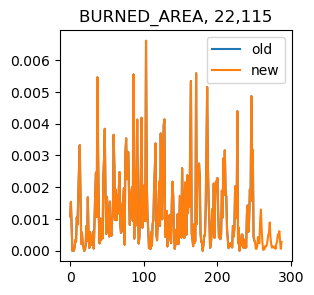

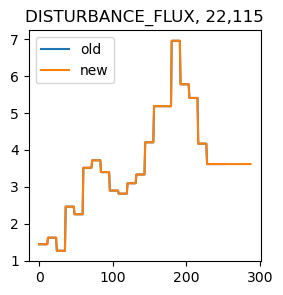

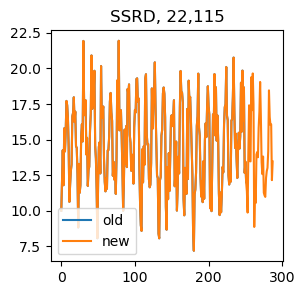

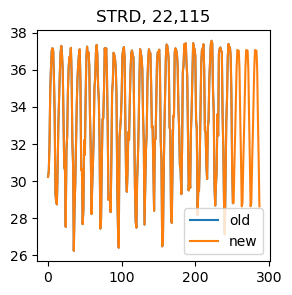

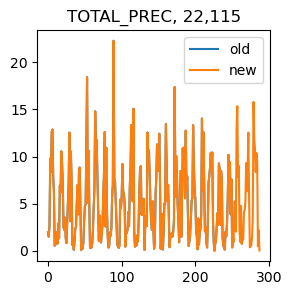

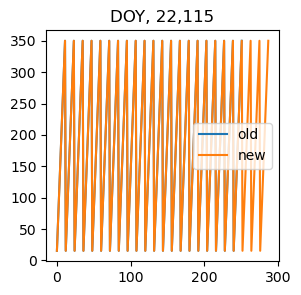

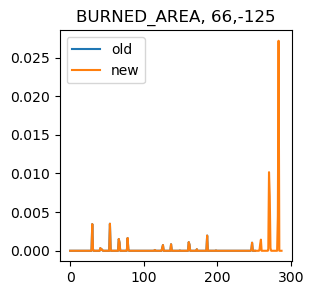

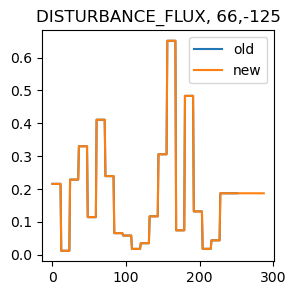

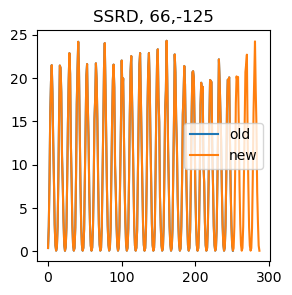

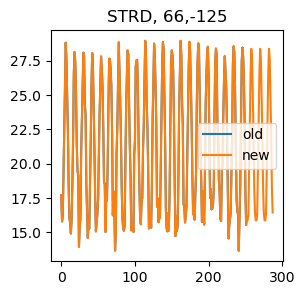

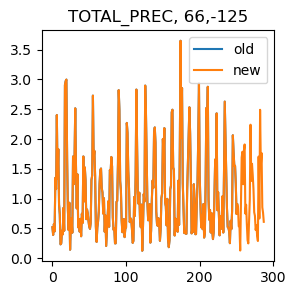

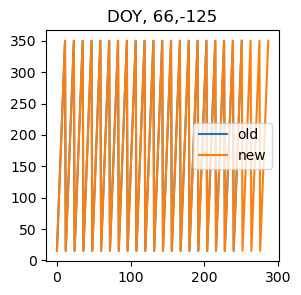

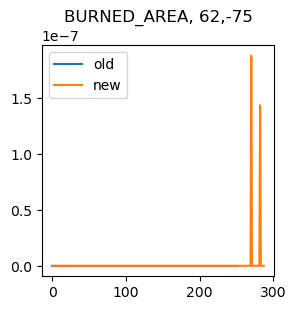

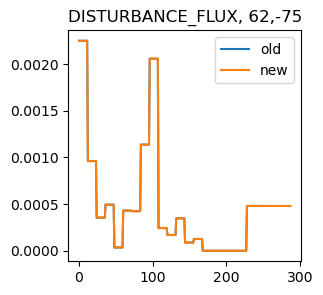

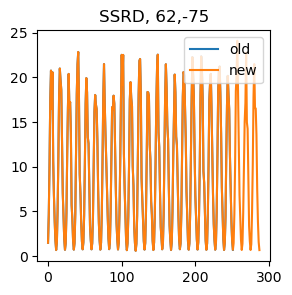

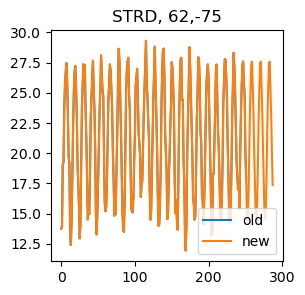

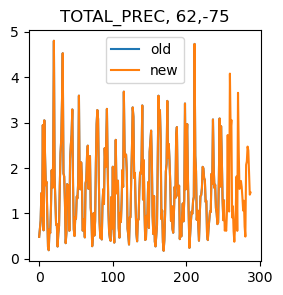

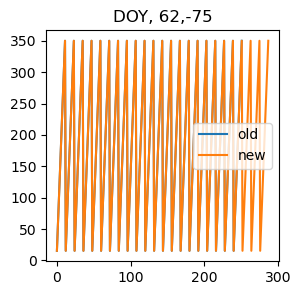

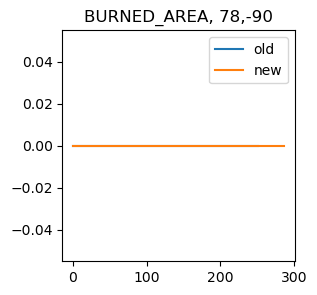

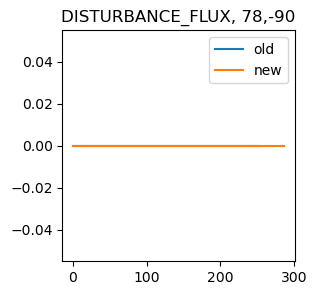

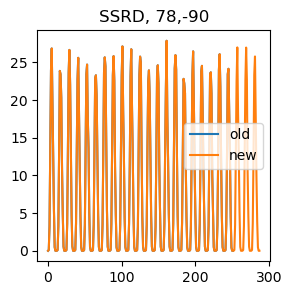

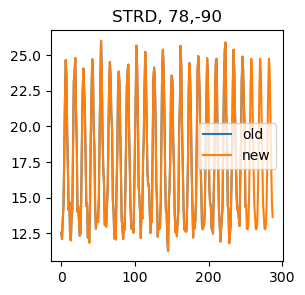

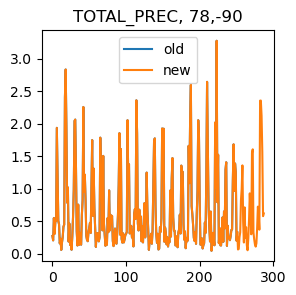

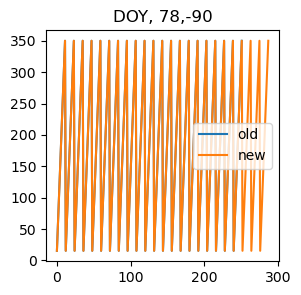

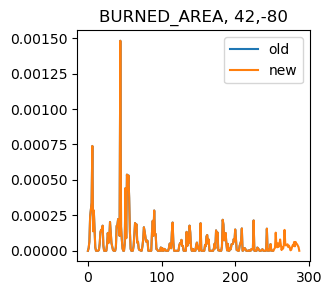

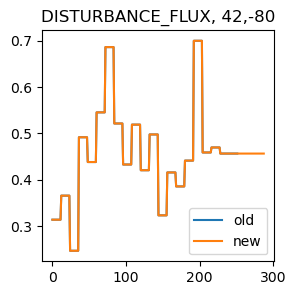

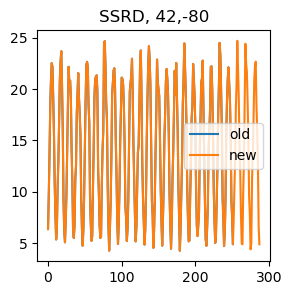

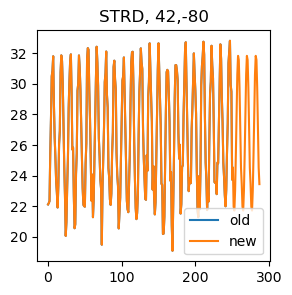

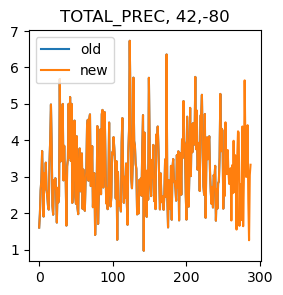

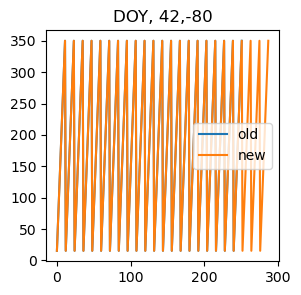

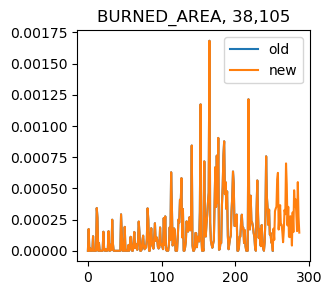

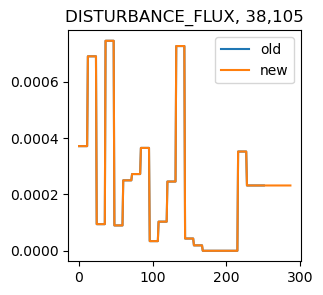

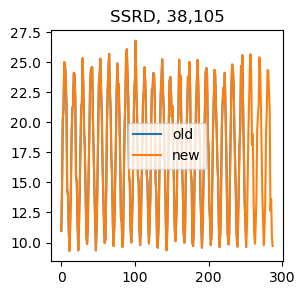

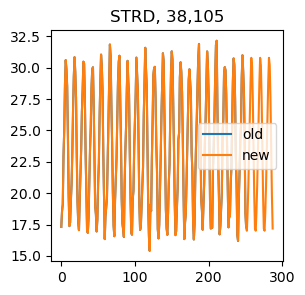

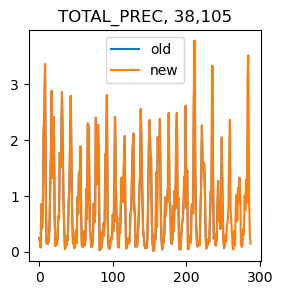

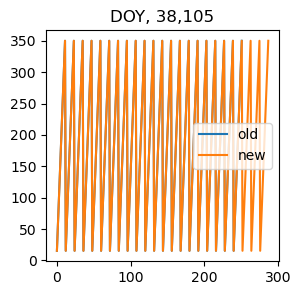

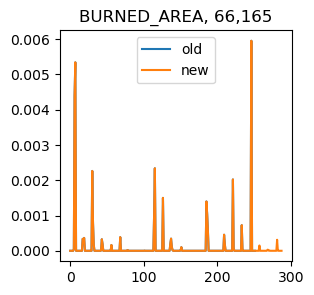

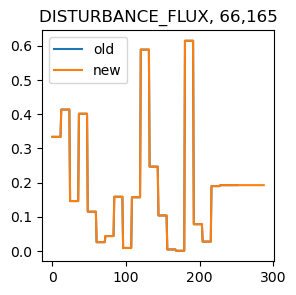

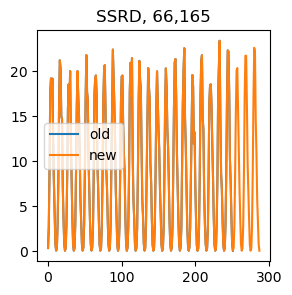

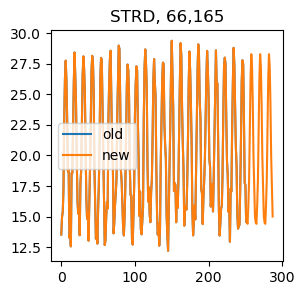

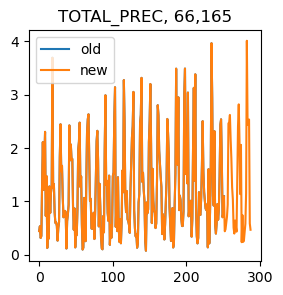

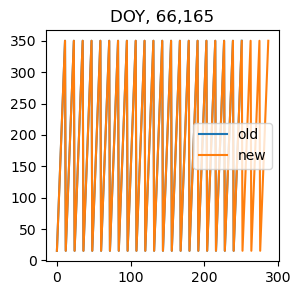

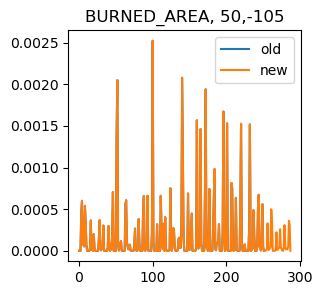

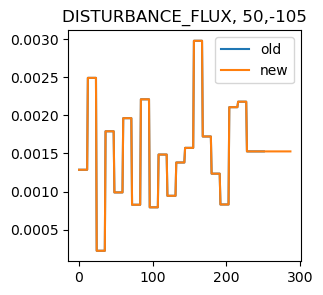

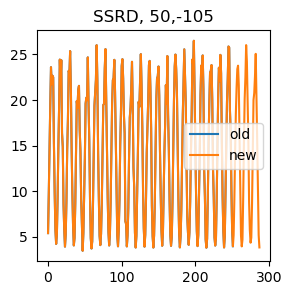

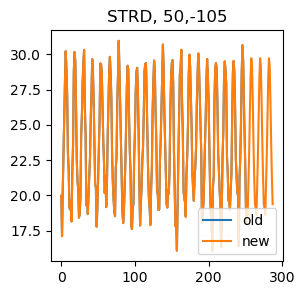

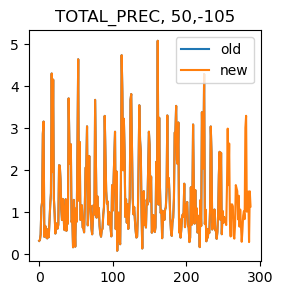

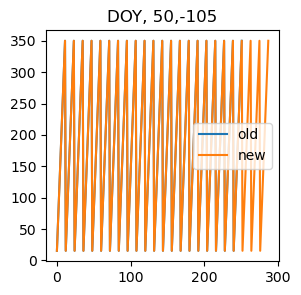

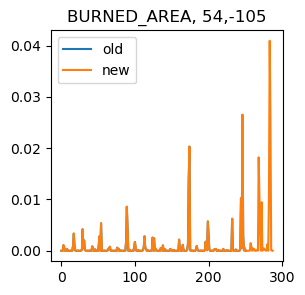

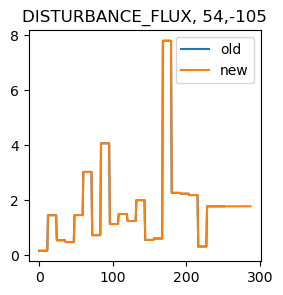

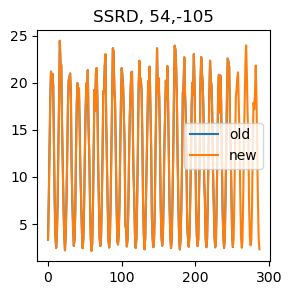

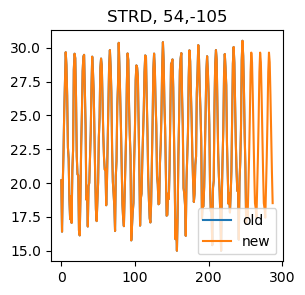

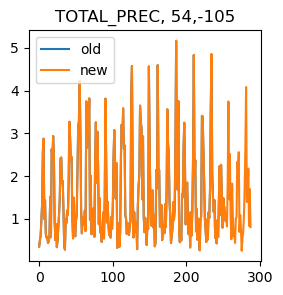

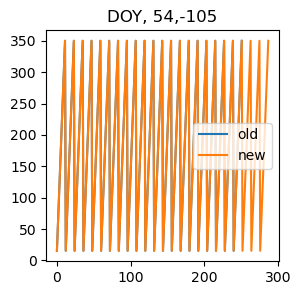

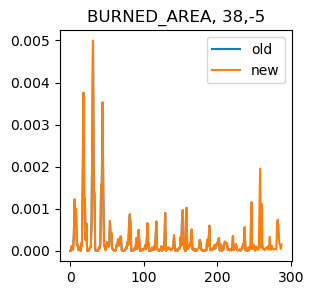

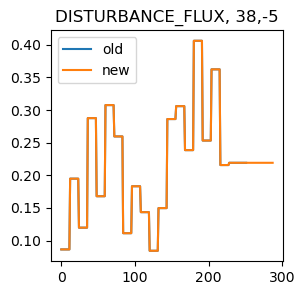

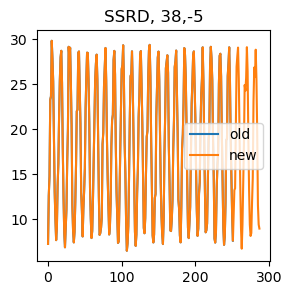

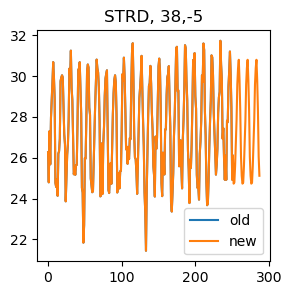

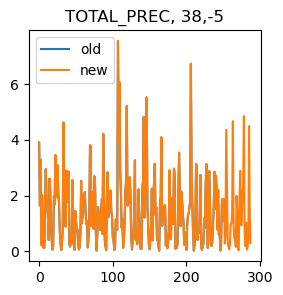

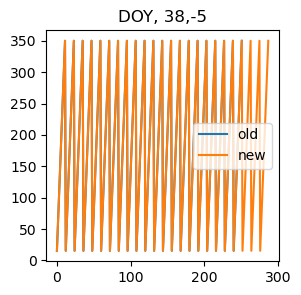

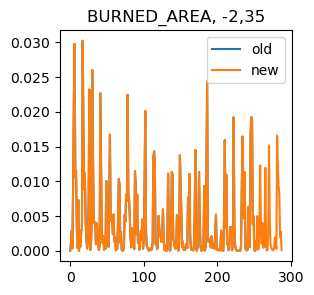

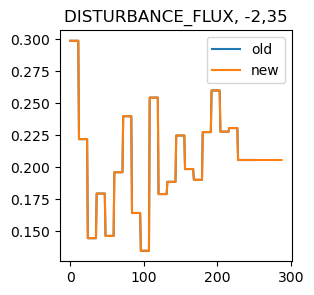

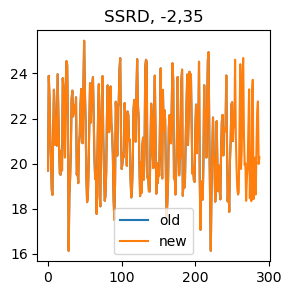

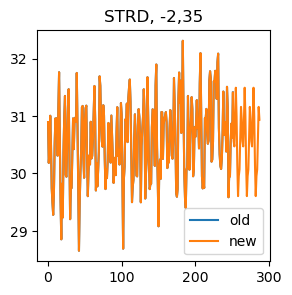

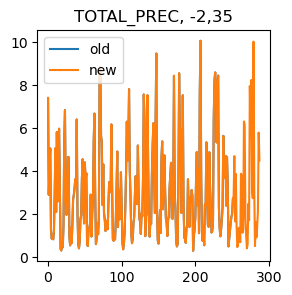

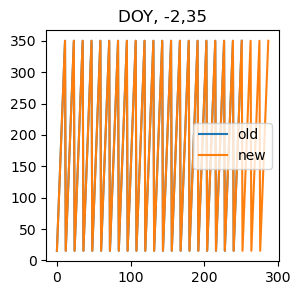

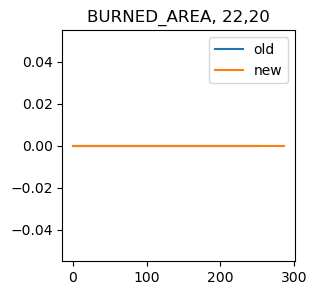

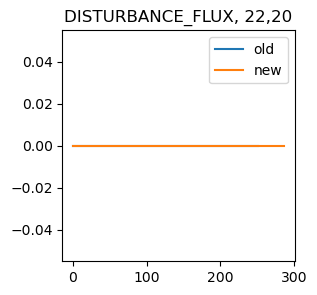

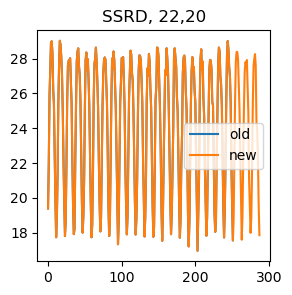

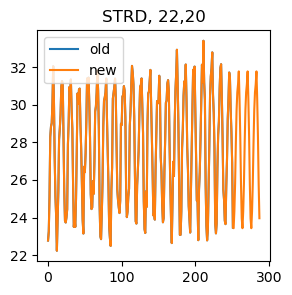

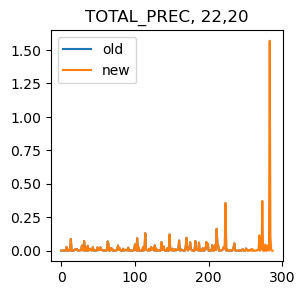

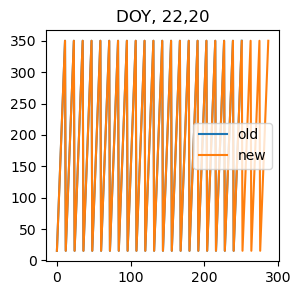

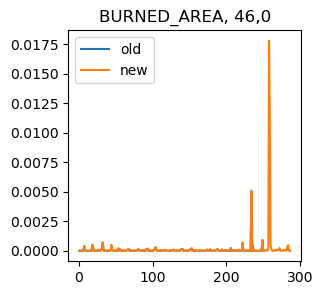

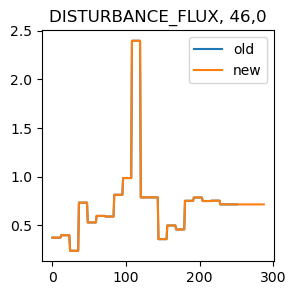

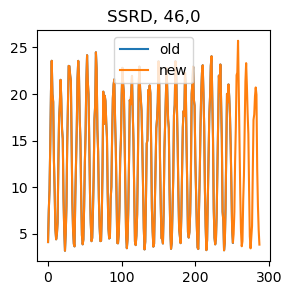

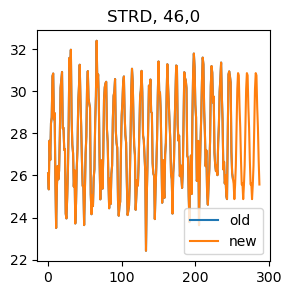

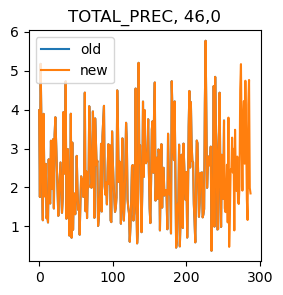

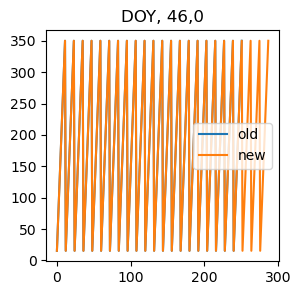

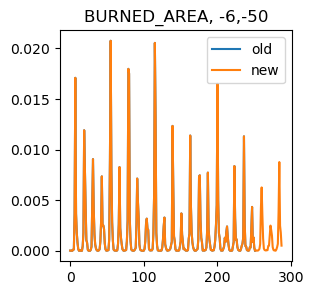

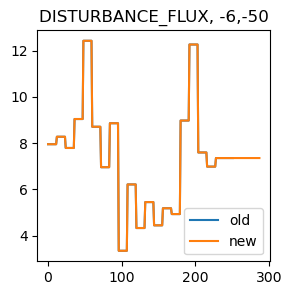

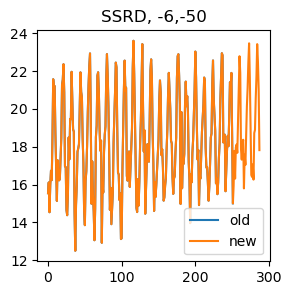

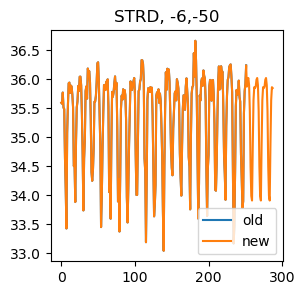

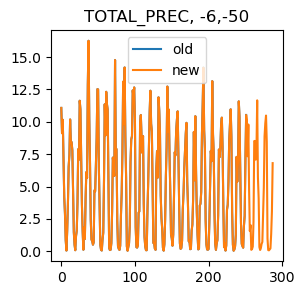

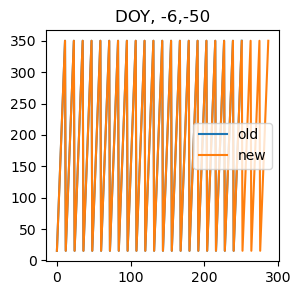

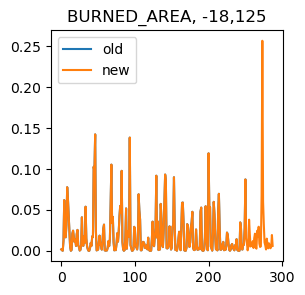

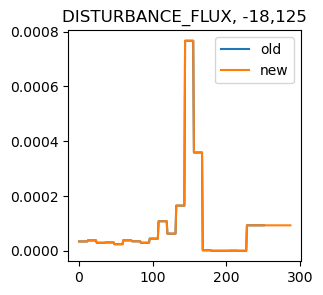

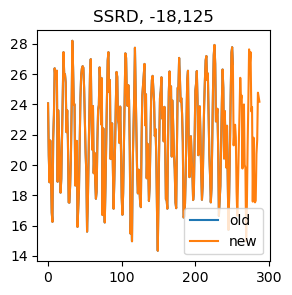

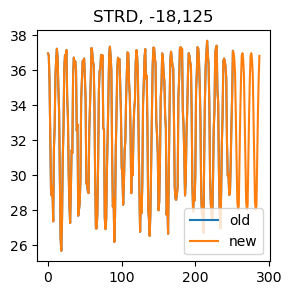

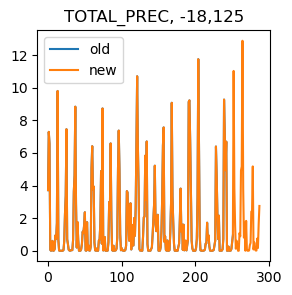

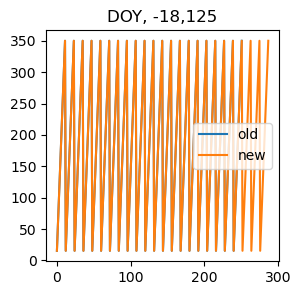

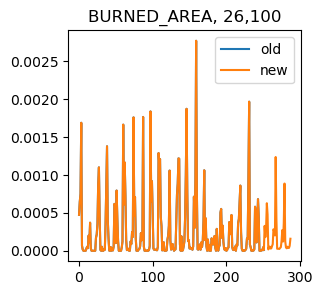

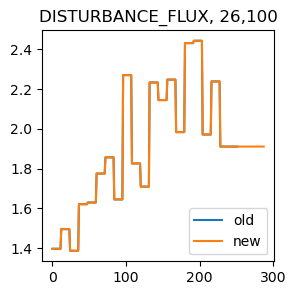

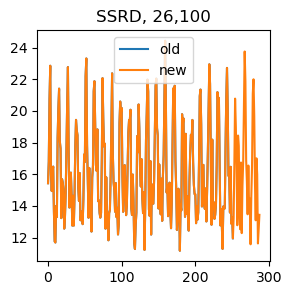

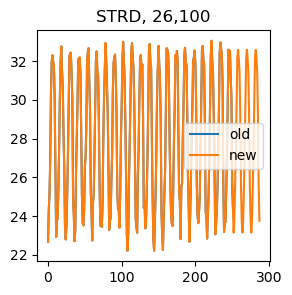

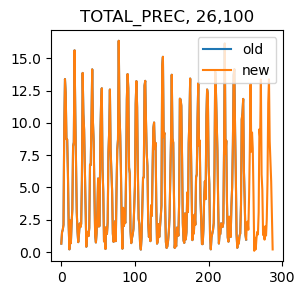

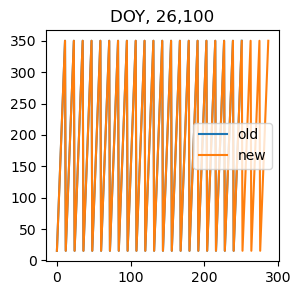

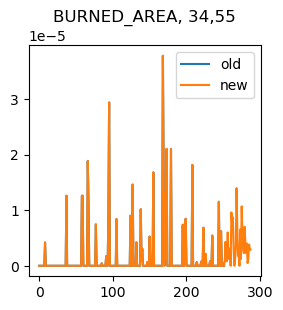

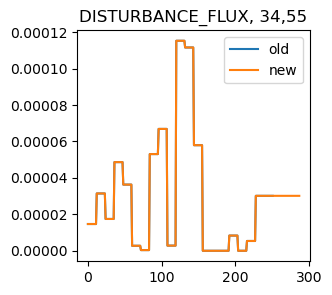

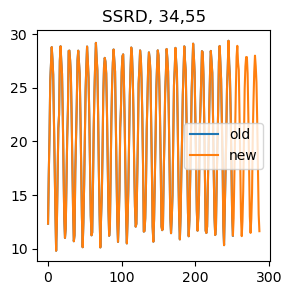

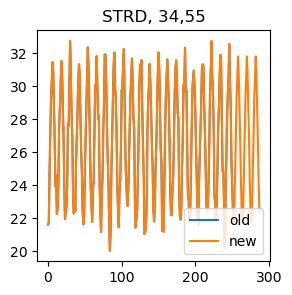

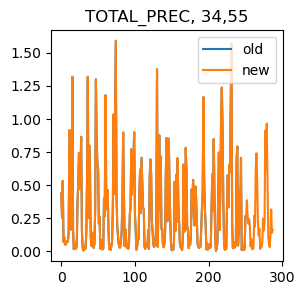

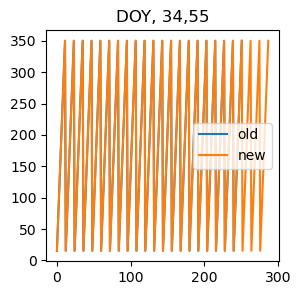

In [20]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

oldCBF=xr.load_dataset(filelist_cbf1100old[0]).reindex(time=AllMet4x5.time, fill_value=np.nan)
# Your input time dimension array
time_dimension = oldCBF.time.data

# Initialize an empty array to store the results
decimal_days_in_year = np.empty_like(time_dimension, dtype=float)

# Iterate through each datetime and calculate days since Jan 1 of its year
for i, dt in enumerate(time_dimension):
    # Extract the year from the datetime object
    year = dt.astype('datetime64[Y]').astype(int) + 1970 # +1970 because datetime64[Y] gives years since 1970

    # Create a datetime object for January 1st of that specific year
    jan1_of_year = np.datetime64(f'{year}-01-01T00:00:00.000000000')

    # Calculate the difference
    time_difference = dt - jan1_of_year

    # Convert to decimal days and store
    decimal_days_in_year[i] = time_difference / np.timedelta64(1, 'D')

# list(zip(decimal_days_in_year,oldCBF.DOY.data))


for i in np.arange(len(filelist_cbf1100old)):  
    temp=xr.open_dataset(filelist_cbf1100old[i])
    temp2=temp.reindex(time=AllMet4x5.time, fill_value=np.nan) #this kind of copying keeps all old HFDF14 metadata (i.e. data attributes like uncertainties)
    LAT=int(temp.LAT.data) 
    LON=int(temp.LON.data)

    for n in list(x for x in AllMet4x5.data_vars if x in temp.data_vars and 'DIST' not in x): 
        temp2[n][dict(time=np.arange(252,288))]=AllMet4x5[n][dict(latitude=np.where(AllMet4x5.latitude==LAT)[0][0], 
                                                                  longitude=np.where(AllMet4x5.longitude==LON)[0][0], 
                                                                  time=np.arange(252,288))].data

#YIELD driver must be set to zero when we lack data (nan doesn't work)
    temp2['YIELD'][dict(time=np.arange(252,288))]=np.zeros(36)
#DISTURBANCE_FLUX driver extended by time series mean, but regridding differences mean the version in AllMet4x5 doesn't always match. So do this here. 
    temp2['DISTURBANCE_FLUX'][dict(time=np.arange(252,288))]=np.ones(36)*temp['DISTURBANCE_FLUX'].mean('time').data
    
    temp2['DOY'][dict(time=np.arange(252,288))]=decimal_days_in_year[252:]
    for n in list(x for x in oldCBF.data_vars if 
                  x not in AllMet4x5.data_vars and #not a driver
                  len(oldCBF[x].shape)>0 and #not single values (e.g. PEQs, MCMCID stuff)
                  'YIELD' not in x and #manually exclude YIELD
                  'DOY' not in x): #manually exclude DOY; resulting list grabs all the time series data constraints 
    
        temp2[n].encoding['_FillValue']= '-9999.'
        
    temp2['time'].encoding['units']= 'days since 2001-01-01'
    
    temp2.to_netcdf(filelist_cbf1100new[i])

    if i%50==0:
        plt.figure(figsize=(3,3))
        plt.plot(temp.BURNED_AREA,label='old')
        plt.plot(temp2.BURNED_AREA,label='new')
        plt.title('BURNED_AREA, ' +str(LAT) +','+str(LON))
        plt.legend()

        plt.figure(figsize=(3,3))
        plt.plot(temp.DISTURBANCE_FLUX,label='old')
        plt.plot(temp2.DISTURBANCE_FLUX,label='new')
        plt.title('DISTURBANCE_FLUX, ' +str(LAT) +','+str(LON))
        plt.legend()

        plt.figure(figsize=(3,3))
        plt.plot(temp.SSRD,label='old')
        plt.plot(temp2.SSRD,label='new')
        plt.title('SSRD, ' +str(LAT) +','+str(LON))
        plt.legend()

        plt.figure(figsize=(3,3))
        plt.plot(temp.STRD,label='old')
        plt.plot(temp2.STRD,label='new')
        plt.title('STRD, ' +str(LAT) +','+str(LON))
        plt.legend()

        plt.figure(figsize=(3,3))
        plt.plot(temp.TOTAL_PREC,label='old')
        plt.plot(temp2.TOTAL_PREC,label='new')
        plt.title('TOTAL_PREC, ' +str(LAT) +','+str(LON))
        plt.legend()
        
        plt.figure(figsize=(3,3))
        plt.plot(temp.DOY,label='old')
        plt.plot(temp2.DOY,label='new')
        plt.title('DOY, ' +str(LAT) +','+str(LON))
        plt.legend()

warnings.filterwarnings("default")
